In [86]:
# Core
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Deep learning Models
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.optimizers import Adam

# Performance Metrics
from sklearn.metrics import classification_report, confusion_matrix

# Utilities
import os
import joblib
import glob

In [87]:
import tensorflow as tf
print(tf.__version__)

2.20.0


In [88]:
import tensorflow as tf
print(tf.test.is_gpu_available())        # For TF < 2.5
print(tf.config.list_physical_devices()) # For TF 2.5+

False
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


# Phase 1: Data Loading

Load Dataset

In [89]:
# Main dataset directory
DATASET_DIR = r"data"

# Subfolders for train, validation, and test
TRAIN_DIR   = os.path.join(DATASET_DIR, "Train")
VAL_DIR     = os.path.join(DATASET_DIR, "Validation")
TEST_DIR    = os.path.join(DATASET_DIR, "Test")

# Check if the folders exist
print("Train exists:", os.path.exists(TRAIN_DIR))
print("Validation exists:", os.path.exists(VAL_DIR))
print("Test exists:", os.path.exists(TEST_DIR))

Train exists: True
Validation exists: True
Test exists: True


In [90]:
# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32 # Process 32 pictures at a time
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

In [91]:
# Load train dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

Found 10000 files belonging to 2 classes.


In [92]:
# Check shape of one batch
for images, labels in train_ds.take(1):
    print("Train batch images shape:", images.shape)
    print("Train batch labels shape:", labels.shape)

Train batch images shape: (32, 224, 224, 3)
Train batch labels shape: (32,)


In [93]:
# Load test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 992 files belonging to 2 classes.


In [94]:
# Check shape of one batch
for images, labels in test_ds.take(1):
    print("Test batch images shape:", images.shape)
    print("Test batch labels shape:", labels.shape)

Test batch images shape: (32, 224, 224, 3)
Test batch labels shape: (32,)


In [95]:
# Load validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

Found 800 files belonging to 2 classes.


In [96]:
# Check shape of one batch
for images, labels in val_ds.take(1):
    print("Validation batch images shape:", images.shape)
    print("Validation batch labels shape:", labels.shape)

Validation batch images shape: (32, 224, 224, 3)
Validation batch labels shape: (32,)


# Phase 2: Data Visualization


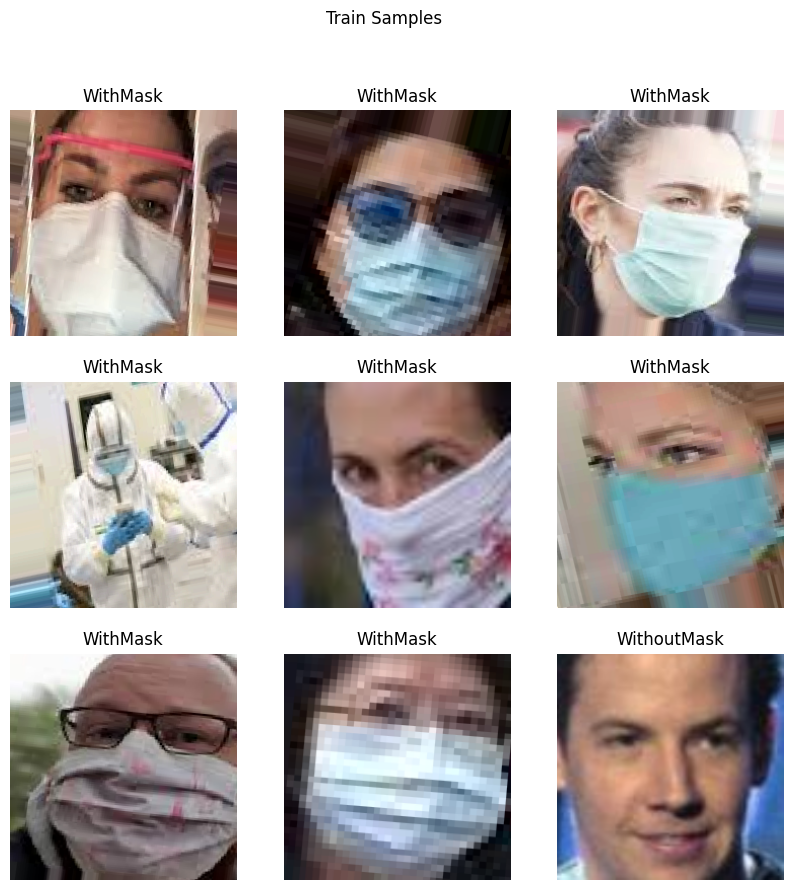

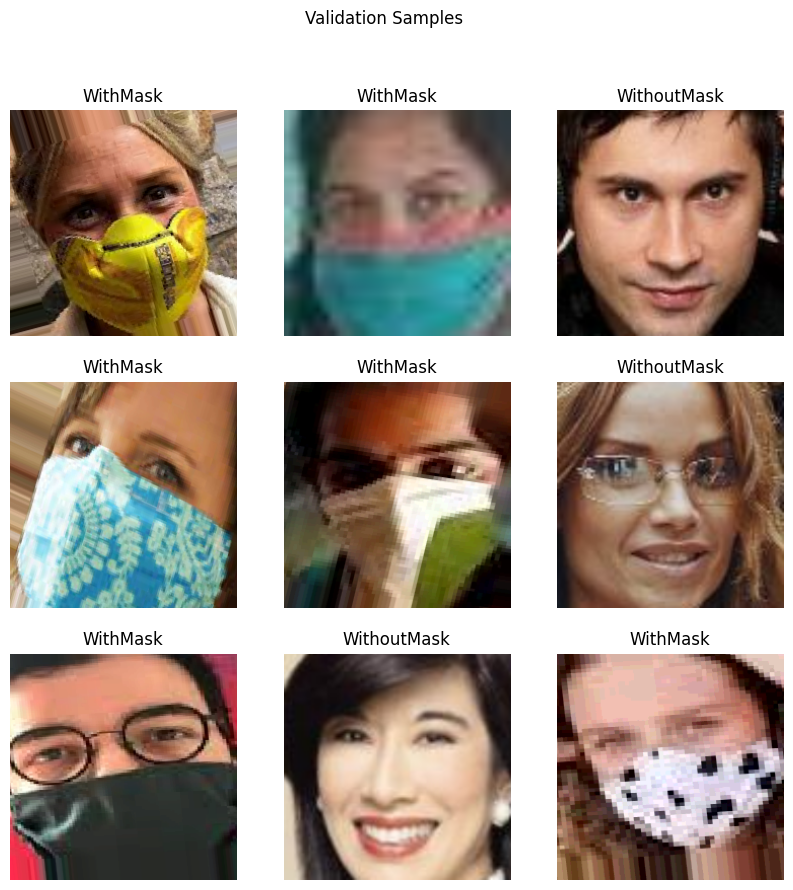

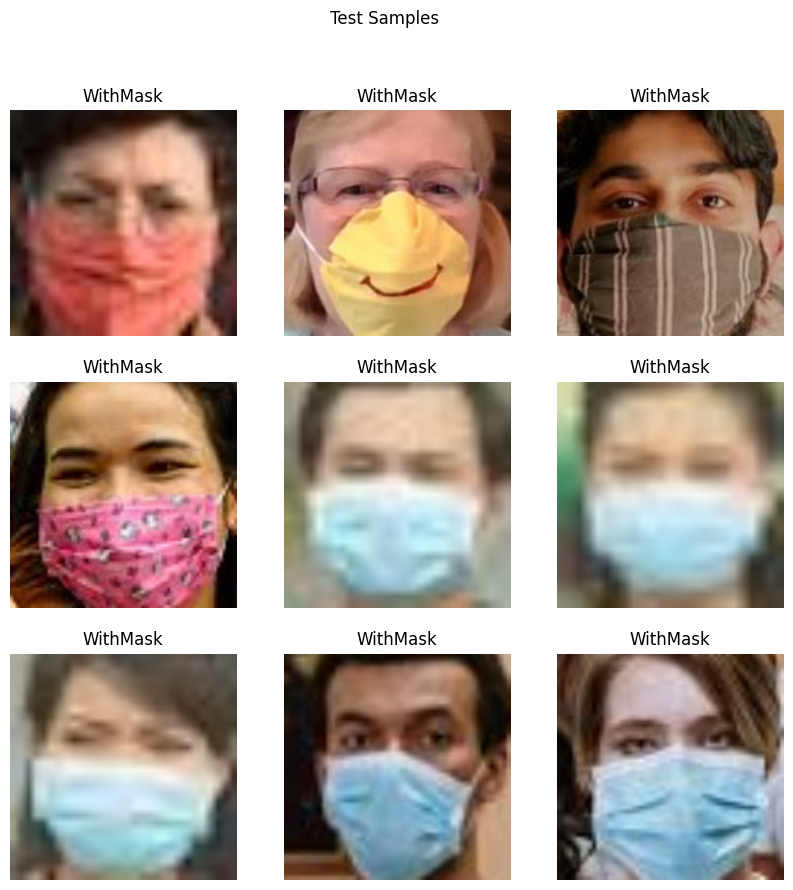

In [97]:
def show_samples(ds, title):
    class_names = ds.class_names
    plt.figure(figsize=(10,10))
    for images, labels in ds.take(1):
        for i in range(9):
            ax = plt.subplot(3,3,i+1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
    plt.suptitle(title)
    plt.show()

show_samples(train_ds, "Train Samples")
show_samples(val_ds, "Validation Samples")
show_samples(test_ds, "Test Samples")

### Plot class distribution

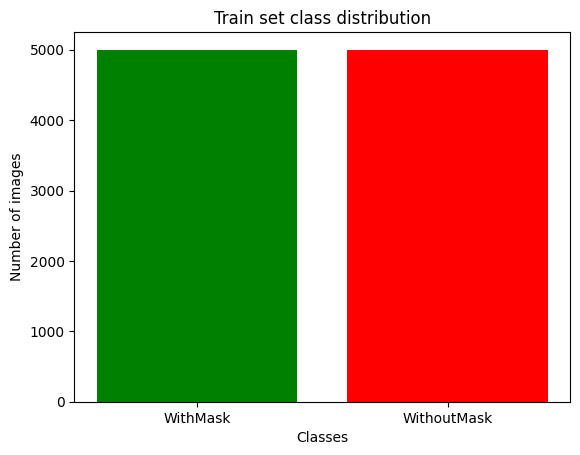

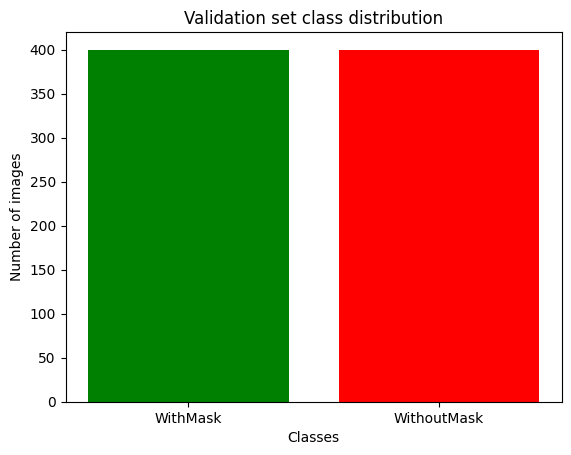

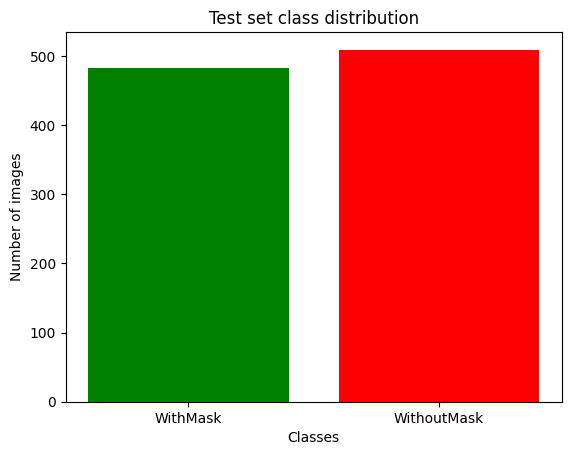

In [98]:
def plot_distribution(directory, labels, title):
    counts = [len(glob.glob(os.path.join(directory, cls, "*"))) for cls in labels]
    plt.bar(labels, counts, color=['green','red'])
    plt.title(title)
    plt.xlabel("Classes")
    plt.ylabel("Number of images")
    plt.show()

labels = ["WithMask", "WithoutMask"]
plot_distribution(TRAIN_DIR, labels, "Train set class distribution")
plot_distribution(VAL_DIR, labels, "Validation set class distribution")
plot_distribution(TEST_DIR, labels, "Test set class distribution")

# Phase 3: Data Preprocessing & Augmentation

In [99]:
# Data Augmentation for CNN (tf layers) - Fixed to maintain image dimensions
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.15, fill_mode="constant")  # Use constant fill to maintain size
])

 Preprocessing functions

In [100]:
# For CNN from scratch
def preprocess_cnn(image, label):
    image = image / 255.0
    return image, label

In [101]:
# For MobileNetV2
def preprocess_mobilenet(image, label):
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

In [102]:
# For ResNet50
def preprocess_resnet(image, label):
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image, label

Apply preprocessing + augmentation

In [103]:
# CNN dataset
train_ds_cnn = train_ds.map(preprocess_cnn).map(lambda x, y: (data_augmentation(x, training=True), y))
val_ds_cnn   = val_ds.map(preprocess_cnn)
test_ds_cnn  = test_ds.map(preprocess_cnn)

In [104]:
# MobileNet dataset
train_ds_mobilenet = train_ds.map(preprocess_mobilenet)
val_ds_mobilenet   = val_ds.map(preprocess_mobilenet)
test_ds_mobilenet  = test_ds.map(preprocess_mobilenet)

In [105]:
# ResNet dataset
train_ds_resnet = train_ds.map(preprocess_resnet)
val_ds_resnet   = val_ds.map(preprocess_resnet)
test_ds_resnet  = test_ds.map(preprocess_resnet)

 Performance optimization

In [106]:
def optimize_dataset(ds):
    return ds.cache().prefetch(buffer_size=AUTOTUNE)

train_ds_cnn = optimize_dataset(train_ds_cnn)
val_ds_cnn   = optimize_dataset(val_ds_cnn)
test_ds_cnn  = optimize_dataset(test_ds_cnn)

train_ds_mobilenet = optimize_dataset(train_ds_mobilenet)
val_ds_mobilenet   = optimize_dataset(val_ds_mobilenet)
test_ds_mobilenet  = optimize_dataset(test_ds_mobilenet)

train_ds_resnet = optimize_dataset(train_ds_resnet)
val_ds_resnet   = optimize_dataset(val_ds_resnet)
test_ds_resnet  = optimize_dataset(test_ds_resnet)

# Phase 4: Building Models

In [ ]:
# CNN from scratch (with built-in augmentation) - Rebuild to fix dimensions
cnn_model = models.Sequential([
    layers.Input(shape=(224,224,3)),
    data_augmentation,  # Add augmentation as first layer
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')  # 2 classes
])

# Print model summary to verify architecture
cnn_model.summary()

In [108]:
cnn_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Transfer Learning

In [109]:
# MobileNetV2
base_mobilenet = MobileNetV2(input_shape=(224,224,3),
                             include_top=False,
                             weights='imagenet')
base_mobilenet.trainable = False  # freeze base

mobilenet_model = models.Sequential([
    base_mobilenet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

In [110]:
mobilenet_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [111]:
# ResNet50
base_resnet = ResNet50(input_shape=(224,224,3),
                       include_top=False,
                       weights='imagenet')
base_resnet.trainable = False  # freeze base

resnet_model = models.Sequential([
    base_resnet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

In [112]:
resnet_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Phase 5: Training & Validation (Loss & Accuracy) Curves

In [ ]:
# Training CNN Model (Person 1's model)
history_cnn = cnn_model.fit(
    train_ds_cnn,
    validation_data=val_ds_cnn,
    epochs=5,
    verbose=1
)

Epoch 1/10
260/313 ━━━━━━━━━━━━━━━━━━━━ 24s 459ms/step - accuracy: 0.8438 - loss: 0.3426

KeyboardInterrupt: 

In [ ]:
# Training MobileNetV2 Model (Person 1's model)
history_mobilenet = mobilenet_model.fit(
    train_ds_mobilenet,
    validation_data=val_ds_mobilenet,
    epochs=5,
    verbose=1
)

In [ ]:
# Training ResNet50 Model (Person 1's model)
history_resnet = resnet_model.fit(
    train_ds_resnet,
    validation_data=val_ds_resnet,
    epochs=5,
    verbose=1
)